In [15]:
# CELL 1: Imports
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass, label
import pandas as pd

In [16]:
# CELL 2: Paths and Configuration
BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SUBJECTS = {
    'sub-004': {'code': 'UD', 'sessions': ['01', '02', '03', '05', '06'], 'hemi': 'l'},
    'sub-021': {'code': 'TC', 'sessions': ['01', '02', '03'], 'hemi': 'r'}
}

COPE_MAP = {
    'face': 1,
    'house': 2,
    'object': 3,
    'word': 4
}

print(f"Base: {BASE_DIR}")
print(f"Output: {OUTPUT_DIR}")

Base: /user_data/csimmon2/long_pt
Output: /user_data/csimmon2/long_pt/analyses/rsa_corrected


In [4]:
# CELL 3: Identify peaks using run-pair averaging (baseline session)
def identify_runpair_peaks_baseline(subject_id, threshold_z=2.0, min_voxels=5):
    code = SUBJECTS[subject_id]['code']
    hemi = SUBJECTS[subject_id]['hemi']
    
    print(f"\n{'='*70}")
    print(f"{code}: Identifying Peaks (run pairs, z>{threshold_z})")
    print(f"{'='*70}")
    
    peak_coords = {}
    
    for category, zstat_num in COPE_MAP.items():
        # Baseline session
        if subject_id == 'sub-004' and category == 'word':
            baseline_session = '02'
        else:
            baseline_session = '01'
        
        print(f"\n{category.upper()} (baseline: ses-{baseline_session}):")
        
        # Load parcel mask
        parcel_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        if not parcel_file.exists():
            print(f"  No parcel mask")
            continue
        
        parcel_mask = nib.load(parcel_file).get_fdata() > 0
        parcel_img = nib.load(parcel_file)
        affine = parcel_img.affine
        brain_shape = parcel_img.shape
        
        # Get runs
        loc_dir = BASE_DIR / subject_id / f'ses-{baseline_session}' / 'derivatives' / 'fsl' / 'loc'
        run_dirs = sorted([d for d in loc_dir.glob('run-*') if d.is_dir()])
        runs = list(range(len(run_dirs)))
        
        if len(runs) < 2:
            print(f"  Need ≥2 runs")
            continue
        
        # Generate run pairs
        run_combos = [(r1, r2) for r1 in runs for r2 in runs if r1 < r2]
        print(f"  {len(run_dirs)} runs → {len(run_combos)} pairs")
        
        pair_peaks = []
        
        for idx, (r1, r2) in enumerate(run_combos):
            # Load both zstats
            zstat1_file = run_dirs[r1] / '1stLevel.feat' / 'reg_standard' / 'stats' / f'zstat{zstat_num}.nii.gz'
            zstat2_file = run_dirs[r2] / '1stLevel.feat' / 'reg_standard' / 'stats' / f'zstat{zstat_num}.nii.gz'
            
            if not (zstat1_file.exists() and zstat2_file.exists()):
                continue
            
            # Average pair
            zstat1 = nib.load(zstat1_file).get_fdata()
            zstat2 = nib.load(zstat2_file).get_fdata()
            mean_zstat = (zstat1 + zstat2) / 2
            
            # Threshold and mask
            roi_mask = (mean_zstat > threshold_z) & parcel_mask
            
            if roi_mask.sum() < min_voxels:
                continue
            
            # Find peak
            peak_idx = np.unravel_index(np.argmax(mean_zstat * roi_mask), mean_zstat.shape)
            peak_coord = nib.affines.apply_affine(affine, peak_idx)
            peak_z = mean_zstat[peak_idx]
            
            pair_peaks.append({
                'index': idx,
                'run_pair': (r1, r2),
                'coord': peak_coord,
                'z_value': peak_z,
                'n_voxels': int(roi_mask.sum())
            })
            
            print(f"    Pair {idx} (runs {r1}-{r2}): peak={peak_coord}, z={peak_z:.2f}")
        
        if len(pair_peaks) > 0:
            peak_coords[category] = {
                'pair_peaks': pair_peaks,
                'baseline_session': baseline_session,
                'affine': affine,
                'brain_shape': brain_shape
            }
            print(f"  → {len(pair_peaks)} valid pairs")
    
    return peak_coords

# Run
ud_peaks = identify_runpair_peaks_baseline('sub-004', threshold_z=2.0)
tc_peaks = identify_runpair_peaks_baseline('sub-021', threshold_z=2.0)


UD: Identifying Peaks (run pairs, z>2.0)

FACE (baseline: ses-01):
  3 runs → 3 pairs
    Pair 1 (runs 0-2): peak=[-27.5 -32.   -3. ], z=2.29
  → 1 valid pairs

HOUSE (baseline: ses-01):
  3 runs → 3 pairs
    Pair 0 (runs 0-1): peak=[ -4.5 -78.    5. ], z=4.22
    Pair 1 (runs 0-2): peak=[ -4.5 -76.    6. ], z=5.23
    Pair 2 (runs 1-2): peak=[ -4.5 -79.    5. ], z=3.52
  → 3 valid pairs

OBJECT (baseline: ses-01):
  3 runs → 3 pairs
    Pair 0 (runs 0-1): peak=[-34.5 -64.    4. ], z=3.91
    Pair 1 (runs 0-2): peak=[-29.5 -69.    8. ], z=4.02
    Pair 2 (runs 1-2): peak=[-32.5 -74.   13. ], z=4.80
  → 3 valid pairs

WORD (baseline: ses-02):
  3 runs → 3 pairs
    Pair 0 (runs 0-1): peak=[-40.5 -57.   -2. ], z=4.37
    Pair 2 (runs 1-2): peak=[-29.5 -15.   -5. ], z=2.83
  → 2 valid pairs

TC: Identifying Peaks (run pairs, z>2.0)

FACE (baseline: ses-01):
  3 runs → 3 pairs
    Pair 0 (runs 0-1): peak=[ 33.5 -56.    2. ], z=7.60
    Pair 1 (runs 0-2): peak=[ 33.5 -56.    3. ], z=8.27


In [5]:
# CELL 3B: Load saved sphere coordinates (if already computed)
def load_saved_spheres(subject_id, radius=6):
    """Reconstruct spherical_rois from saved CSV"""
    code = SUBJECTS[subject_id]['code']
    hemi = SUBJECTS[subject_id]['hemi']
    
    csv_file = OUTPUT_DIR / f'{code}_sphere_coords.csv'
    if not csv_file.exists():
        print(f"No saved coords found: {csv_file}")
        return None
    
    df = pd.read_csv(csv_file)
    
    # Load reference image for brain shape
    mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
    ref_img = nib.load(mask_file)
    affine = ref_img.affine
    brain_shape = ref_img.shape
    
    # Reconstruct grid
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]), np.arange(brain_shape[1]), np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    
    spherical_rois = {}
    
    for category in df['category'].unique():
        cat_df = df[df['category'] == category]
        pairs = []
        
        for _, row in cat_df.iterrows():
            peak = np.array([row['peak_x'], row['peak_y'], row['peak_z']])
            distances = np.linalg.norm(grid_world - peak, axis=1)
            
            sphere_mask = np.zeros(brain_shape, dtype=bool)
            within = grid_coords[distances <= radius]
            for coord in within:
                sphere_mask[coord[0], coord[1], coord[2]] = True
            
            pairs.append({
                'index': int(row['pair']),
                'run_pair': eval(row['run_pair']),
                'peak_coord': peak,
                'peak_z': row['peak_z_value'],
                'spheres': {
                    radius: {'mask': sphere_mask, 'n_voxels': int(row['n_voxels'])}
                }
            })
        
        spherical_rois[category] = {'pairs': pairs}
    
    print(f"Loaded {code}: {len(spherical_rois)} ROIs from {csv_file}")
    return spherical_rois

# Load saved spheres
ud_spheres = load_saved_spheres('sub-004', radius=6)
tc_spheres = load_saved_spheres('sub-021', radius=6)

Loaded UD: 4 ROIs from /user_data/csimmon2/long_pt/analyses/rsa_corrected/UD_sphere_coords.csv
Loaded TC: 4 ROIs from /user_data/csimmon2/long_pt/analyses/rsa_corrected/TC_sphere_coords.csv


In [7]:
# CELL 4: Create spheres from peaks
def create_spheres_from_peaks(subject_id, peak_coords, radii=[6, 8, 10]):
    code = SUBJECTS[subject_id]['code']
    
    print(f"\n{'='*70}")
    print(f"{code}: Creating Spheres (radii: {radii}mm)")
    print(f"{'='*70}")
    
    spherical_rois = {}
    
    for category, data in peak_coords.items():
        print(f"\n{category.upper()}:")
        
        affine = data['affine']
        brain_shape = data['brain_shape']
        pair_peaks = data['pair_peaks']
        
        # Pre-compute grid
        grid_coords = np.array(np.meshgrid(
            np.arange(brain_shape[0]),
            np.arange(brain_shape[1]),
            np.arange(brain_shape[2]),
            indexing='ij'
        )).reshape(3, -1).T
        
        grid_world = nib.affines.apply_affine(affine, grid_coords)
        
        category_spheres = []
        
        for pair_data in pair_peaks:
            peak_coord = pair_data['coord']
            distances = np.linalg.norm(grid_world - peak_coord, axis=1)
            
            pair_spheres = {
                'index': pair_data['index'],
                'run_pair': pair_data['run_pair'],
                'peak_coord': peak_coord,
                'peak_z': pair_data['z_value'],
                'spheres': {}
            }
            
            for radius in radii:
                sphere_mask = np.zeros(brain_shape, dtype=bool)
                within = grid_coords[distances <= radius]
                for coord in within:
                    sphere_mask[coord[0], coord[1], coord[2]] = True
                
                pair_spheres['spheres'][radius] = {
                    'mask': sphere_mask,
                    'n_voxels': int(sphere_mask.sum())
                }
            
            category_spheres.append(pair_spheres)
            
            vox_str = ', '.join([f"{r}mm:{pair_spheres['spheres'][r]['n_voxels']}v" for r in radii])
            print(f"  Pair {pair_data['index']}: {vox_str}")
        
        spherical_rois[category] = {
            'pairs': category_spheres,
            'baseline_session': data['baseline_session']
        }
    
    return spherical_rois

# Create spheres
ud_spheres = create_spheres_from_peaks('sub-004', ud_peaks, radii=[6, 8, 10])
tc_spheres = create_spheres_from_peaks('sub-021', tc_peaks, radii=[6, 8, 10])


UD: Creating Spheres (radii: [6, 8, 10]mm)

FACE:
  Pair 1: 6mm:925v, 8mm:2109v, 10mm:4169v

HOUSE:
  Pair 0: 6mm:925v, 8mm:2109v, 10mm:4169v
  Pair 1: 6mm:925v, 8mm:2109v, 10mm:4169v
  Pair 2: 6mm:925v, 8mm:2109v, 10mm:4169v

OBJECT:
  Pair 0: 6mm:925v, 8mm:2109v, 10mm:4169v
  Pair 1: 6mm:925v, 8mm:2109v, 10mm:4169v
  Pair 2: 6mm:925v, 8mm:2109v, 10mm:4169v

WORD:
  Pair 0: 6mm:925v, 8mm:2109v, 10mm:4169v
  Pair 2: 6mm:925v, 8mm:2109v, 10mm:4169v

TC: Creating Spheres (radii: [6, 8, 10]mm)

FACE:
  Pair 0: 6mm:925v, 8mm:2109v, 10mm:4169v
  Pair 1: 6mm:925v, 8mm:2109v, 10mm:4169v
  Pair 2: 6mm:925v, 8mm:2109v, 10mm:4169v

HOUSE:
  Pair 0: 6mm:925v, 8mm:2109v, 10mm:4169v
  Pair 1: 6mm:925v, 8mm:2109v, 10mm:4169v
  Pair 2: 6mm:925v, 8mm:2109v, 10mm:4169v

OBJECT:
  Pair 0: 6mm:925v, 8mm:2109v, 10mm:4169v
  Pair 1: 6mm:925v, 8mm:2109v, 10mm:4169v
  Pair 2: 6mm:925v, 8mm:2109v, 10mm:4169v

WORD:
  Pair 1: 6mm:925v, 8mm:2109v, 10mm:4169v


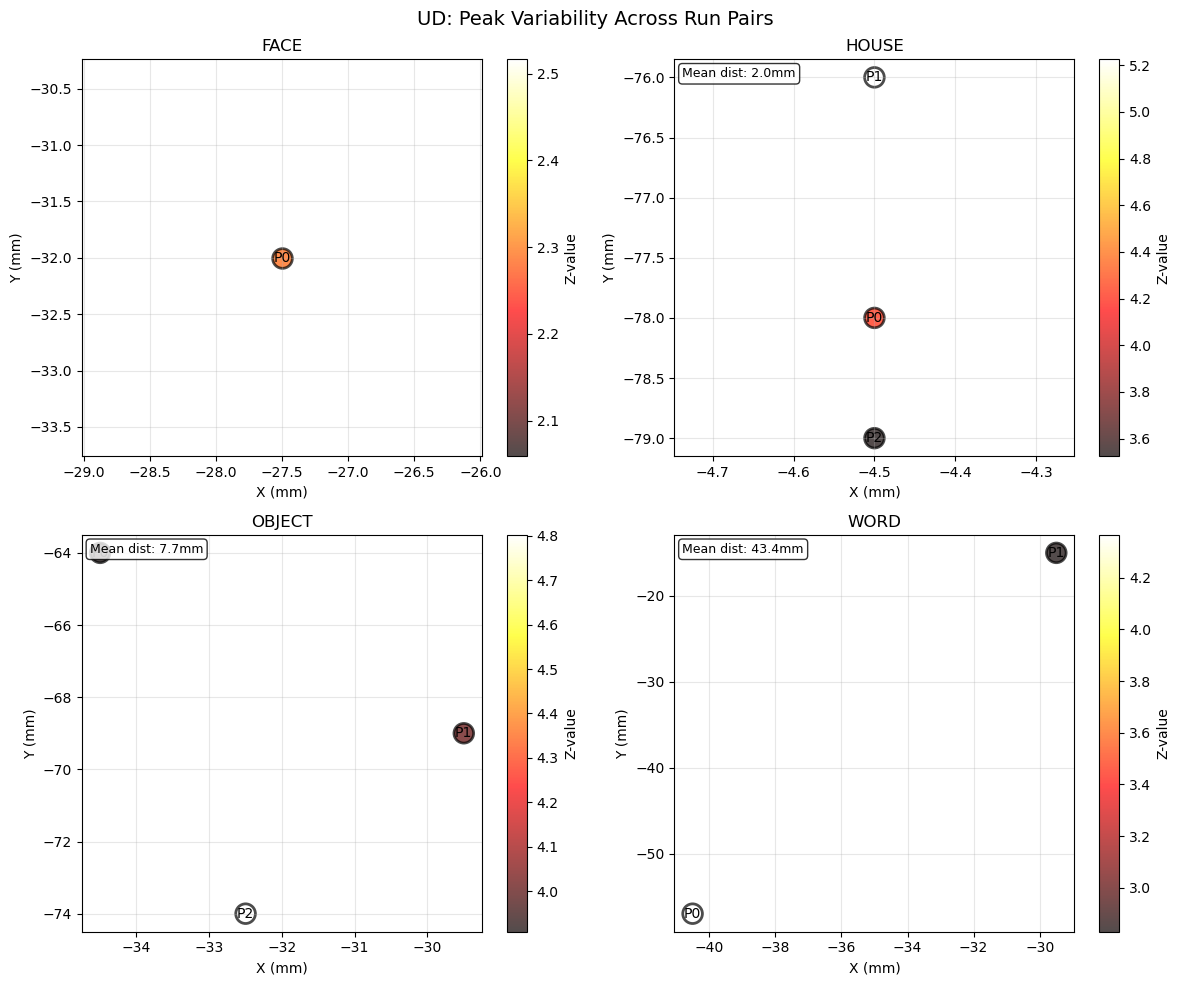

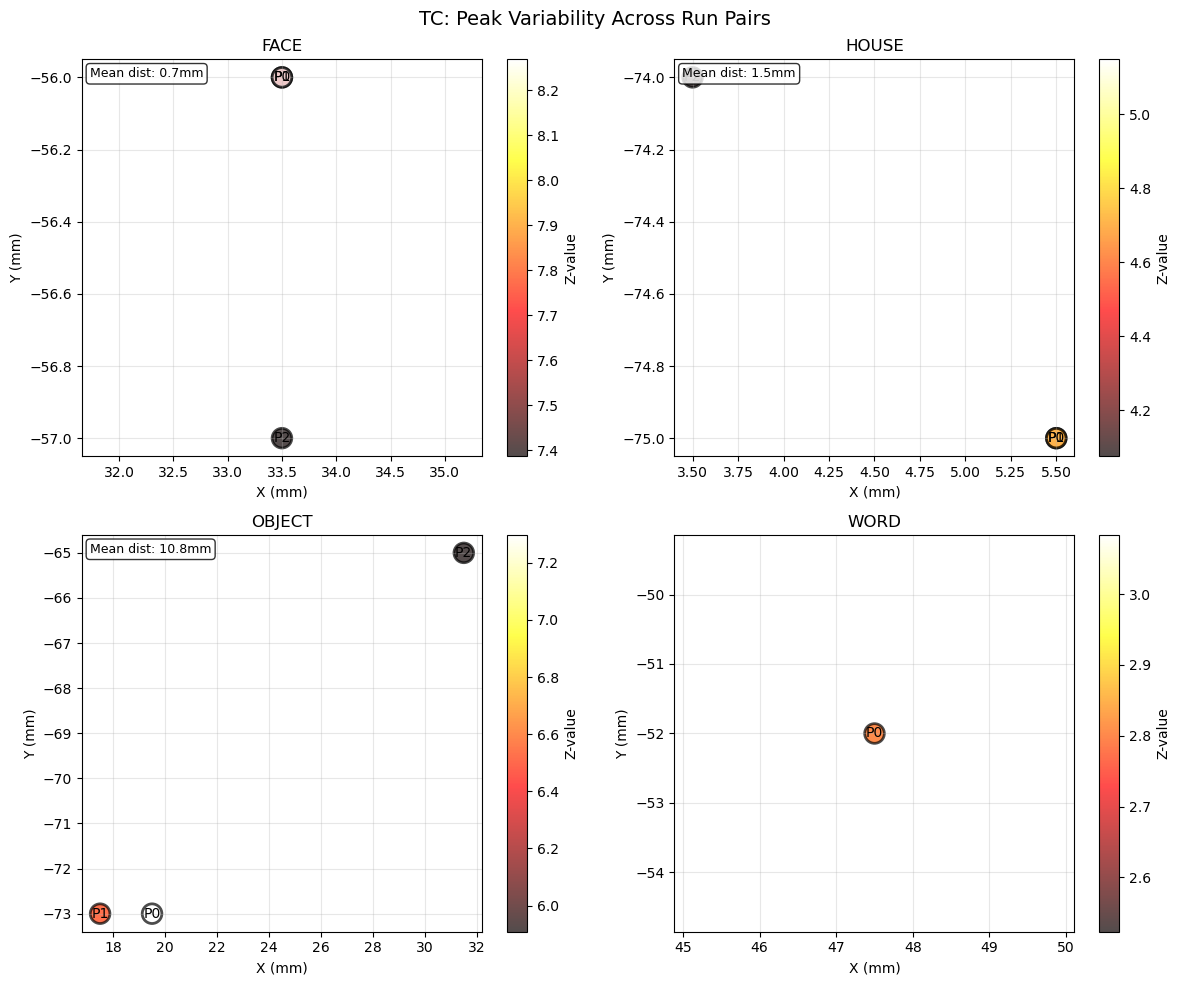

In [6]:
# CELL 5: Visualize peak consistency
def visualize_peak_consistency(subject_id, peak_coords):
    code = SUBJECTS[subject_id]['code']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{code}: Peak Variability Across Run Pairs', fontsize=14)
    
    for idx, (category, data) in enumerate(peak_coords.items()):
        ax = axes[idx // 2, idx % 2]
        
        pair_peaks = data['pair_peaks']
        xs = [p['coord'][0] for p in pair_peaks]
        ys = [p['coord'][1] for p in pair_peaks]
        zs = [p['z_value'] for p in pair_peaks]
        
        scatter = ax.scatter(xs, ys, c=zs, s=200, cmap='hot', 
                           edgecolors='black', linewidths=2, alpha=0.7)
        
        for i, (x, y) in enumerate(zip(xs, ys)):
            ax.annotate(f"P{i}", (x, y), fontsize=10, ha='center', va='center')
        
        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Y (mm)')
        ax.set_title(f'{category.upper()}')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Z-value')
        
        if len(xs) > 1:
            dists = []
            for i in range(len(xs)):
                for j in range(i+1, len(xs)):
                    dists.append(np.sqrt((xs[i]-xs[j])**2 + (ys[i]-ys[j])**2))
            ax.text(0.02, 0.98, f'Mean dist: {np.mean(dists):.1f}mm', 
                   transform=ax.transAxes, va='top', fontsize=9,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'{code}_peak_consistency.png', dpi=150)
    plt.show()

visualize_peak_consistency('sub-004', ud_peaks)
visualize_peak_consistency('sub-021', tc_peaks)

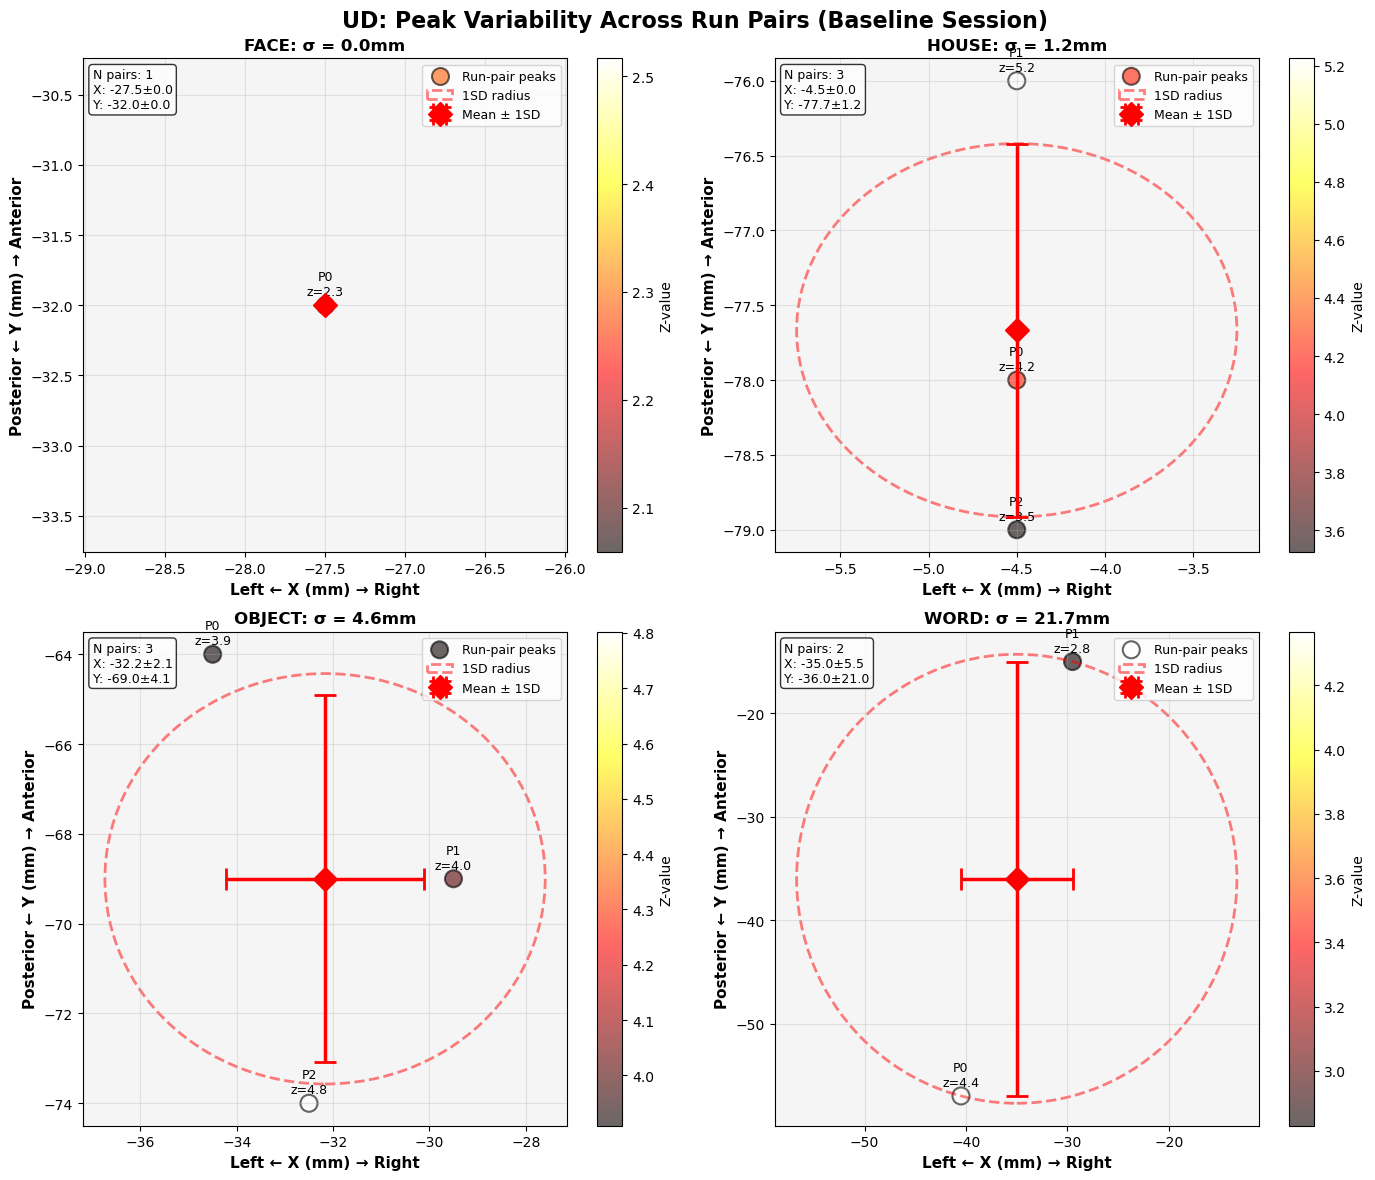

Saved: /user_data/csimmon2/long_pt/analyses/rsa_corrected/UD_peak_consistency_CI.png


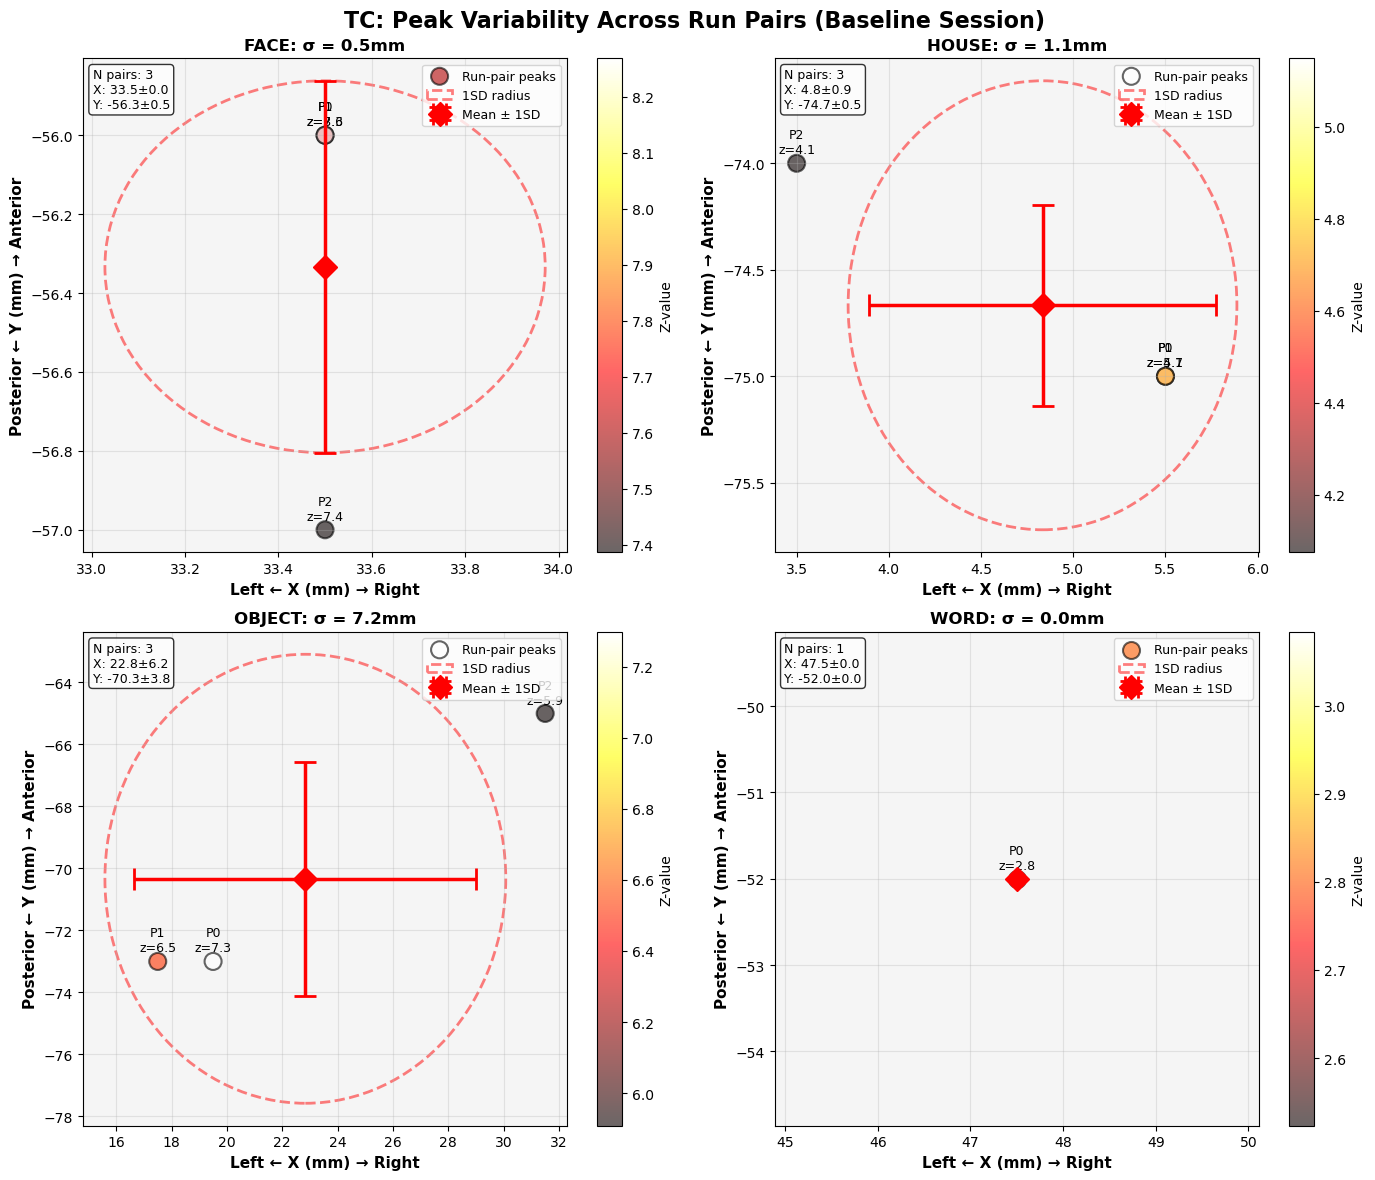

Saved: /user_data/csimmon2/long_pt/analyses/rsa_corrected/TC_peak_consistency_CI.png


In [8]:
# CELL: Visualize Peak Consistency with Confidence Intervals
def visualize_peak_consistency_with_CI(subject_id, peak_coords):
    """Show peak variability across run pairs with error bars"""
    code = SUBJECTS[subject_id]['code']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'{code}: Peak Variability Across Run Pairs (Baseline Session)', fontsize=16, fontweight='bold')
    
    for idx, (category, data) in enumerate(peak_coords.items()):
        ax = axes[idx // 2, idx % 2]
        
        pair_peaks = data['pair_peaks']
        xs = np.array([p['coord'][0] for p in pair_peaks])
        ys = np.array([p['coord'][1] for p in pair_peaks])
        zs = [p['z_value'] for p in pair_peaks]
        
        # Mean and std
        mean_x, std_x = np.mean(xs), np.std(xs)
        mean_y, std_y = np.mean(ys), np.std(ys)
        total_variability = np.sqrt(std_x**2 + std_y**2)
        
        # Plot individual peaks (colored by z-value)
        scatter = ax.scatter(xs, ys, c=zs, s=150, cmap='hot', 
                           alpha=0.6, edgecolors='black', linewidth=1.5,
                           label='Run-pair peaks')
        
        # Annotate each peak
        for i, (x, y, z) in enumerate(zip(xs, ys, zs)):
            ax.annotate(f'P{i}\nz={z:.1f}', (x, y), 
                       fontsize=9, ha='center', va='bottom',
                       xytext=(0, 5), textcoords='offset points')
        
        # Plot mean with error bars (1 SD)
        ax.errorbar(mean_x, mean_y, xerr=std_x, yerr=std_y, 
                   fmt='D', color='red', markersize=12, 
                   capsize=8, capthick=2, linewidth=2.5, 
                   label=f'Mean ± 1SD', zorder=10)
        
        # Add circle showing 1 SD radius
        circle = plt.Circle((mean_x, mean_y), total_variability, 
                           color='red', fill=False, linestyle='--', 
                           linewidth=2, alpha=0.5, label='1SD radius')
        ax.add_patch(circle)
        
        ax.set_xlabel('Left ← X (mm) → Right', fontsize=11, fontweight='bold')
        ax.set_ylabel('Posterior ← Y (mm) → Anterior', fontsize=11, fontweight='bold')
        ax.set_title(f'{category.upper()}: σ = {total_variability:.1f}mm', 
                    fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right', fontsize=9)
        ax.set_facecolor('#F5F5F5')
        
        # Add stats text box
        stats_text = f'N pairs: {len(xs)}\nX: {mean_x:.1f}±{std_x:.1f}\nY: {mean_y:.1f}±{std_y:.1f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
               fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.colorbar(scatter, ax=ax, label='Z-value')
    
    plt.tight_layout()
    output_file = OUTPUT_DIR / f'{code}_peak_consistency_CI.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {output_file}")

# Run for both subjects
visualize_peak_consistency_with_CI('sub-004', ud_peaks)
visualize_peak_consistency_with_CI('sub-021', tc_peaks)

In [ ]:
There has to be more to this...I have to understand more or figure out what to do with this data. I have control data I can run as well but hasn't this all been done before. . .? So If I can do something novel with the control data than the patient data only strengthens it. 

In [14]:
# CELL 6: Save sphere coordinates
def save_sphere_coords(subject_id, spherical_rois, radius=8):
    code = SUBJECTS[subject_id]['code']
    coords_list = []
    
    for category, roi_data in spherical_rois.items():
        for pair_data in roi_data['pairs']:
            coords_list.append({
                'subject': code,
                'category': category,
                'pair': pair_data['index'],
                'run_pair': str(pair_data['run_pair']),
                'peak_x': pair_data['peak_coord'][0],
                'peak_y': pair_data['peak_coord'][1],
                'peak_z': pair_data['peak_coord'][2],
                'peak_z_value': pair_data['peak_z'],
                'radius': radius,
                'n_voxels': pair_data['spheres'][radius]['n_voxels']
            })
    
    df = pd.DataFrame(coords_list)
    output_file = OUTPUT_DIR / f'{code}_sphere_coords.csv'
    df.to_csv(output_file, index=False)
    print(f"Saved: {output_file}")
    return df

ud_coords = save_sphere_coords('sub-004', ud_spheres)
tc_coords = save_sphere_coords('sub-021', tc_spheres)

NameError: name 'ud_spheres' is not defined

In [7]:
# CELL 7: Extract patterns from LEFT-OUT runs
def extract_sphere_patterns(subject_id, spherical_rois, radius=6):
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    stim_conditions = ['Face', 'House', 'Object', 'Word', 'Scramble']
    
    pair_to_leftout_run = {
        0: 3,  # Pair 0 (runs 1-2) → extract run 3
        1: 2,  # Pair 1 (runs 1-3) → extract run 2
        2: 1   # Pair 2 (runs 2-3) → extract run 1
    }
    
    print(f"\n{'='*70}")
    print(f"{code}: Extracting Patterns (left-out runs)")
    print(f"{'='*70}")
    
    for category, roi_data in spherical_rois.items():
        print(f"\n{category.upper()}:")
        
        for session in sessions:
            print(f"  Session {session}:")
            loc_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc'
            
            for pair_idx, pair_data in enumerate(roi_data['pairs']):
                run_idx = pair_to_leftout_run[pair_idx]
                run_dir = loc_dir / f'run-0{run_idx}'
                
                filtered_func = run_dir / '1stLevel.feat' / 'filtered_func_data_reg.nii.gz'
                if not filtered_func.exists():
                    continue
                
                func_img = nib.load(filtered_func)
                func_data = func_img.get_fdata()
                tr = 2
                
                sphere_mask = pair_data['spheres'][radius]['mask']
                
                for stim_cond in stim_conditions:
                    cov_file = BASE_DIR / subject_id / f'ses-{session}' / 'covs' / f'catloc_{subject_id.replace("sub-", "")}_run-0{run_idx}_{stim_cond}.txt'
                    
                    if not cov_file.exists():
                        continue
                    
                    cov_df = pd.read_csv(cov_file, sep='\s+', header=None, names=['onset', 'duration', 'value'])
                    cov_df = cov_df.astype(float)
                    
                    sphere_timeseries = func_data[sphere_mask].T
                    sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
                    
                    block_patterns = []
                    for _, row in cov_df.iterrows():
                        onset_tr = int(np.round(row['onset'] / tr))
                        duration_tr = int(np.round(row['duration'] / tr))
                        block_data = sphere_timeseries[onset_tr:onset_tr+duration_tr]
                        block_patterns.append(block_data.mean(axis=0))
                    
                    output_file = OUTPUT_DIR / 'patterns' / f'{code}_ses-{session}_run-{run_idx}_{category}_pair-{pair_idx}_{stim_cond}.npy'
                    output_file.parent.mkdir(parents=True, exist_ok=True)
                    np.save(output_file, np.array(block_patterns))
            
            print(f"    Extracted from left-out runs")

extract_sphere_patterns('sub-004', ud_spheres)
extract_sphere_patterns('sub-021', tc_spheres)


UD: Extracting Patterns (left-out runs)

FACE:
  Session 01:
    Extracted from left-out runs
  Session 02:


/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)


    Extracted from left-out runs
  Session 03:
    Extracted from left-out runs
  Session 05:
    Extracted from left-out runs
  Session 06:
    Extracted from left-out runs

HOUSE:
  Session 01:
    Extracted from left-out runs
  Session 02:
    Extracted from left-out runs
  Session 03:
    Extracted from left-out runs
  Session 05:


/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)


    Extracted from left-out runs
  Session 06:
    Extracted from left-out runs

OBJECT:
  Session 01:
    Extracted from left-out runs
  Session 02:
    Extracted from left-out runs
  Session 03:
    Extracted from left-out runs
  Session 05:


/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)


    Extracted from left-out runs
  Session 06:
    Extracted from left-out runs

WORD:
  Session 01:
    Extracted from left-out runs
  Session 02:


/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)


    Extracted from left-out runs
  Session 03:
    Extracted from left-out runs
  Session 05:
    Extracted from left-out runs
  Session 06:
    Extracted from left-out runs

TC: Extracting Patterns (left-out runs)

FACE:
  Session 01:
    Extracted from left-out runs
  Session 02:
    Extracted from left-out runs
  Session 03:
    Extracted from left-out runs

HOUSE:
  Session 01:
    Extracted from left-out runs
  Session 02:
    Extracted from left-out runs
  Session 03:


/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)


    Extracted from left-out runs

OBJECT:
  Session 01:
    Extracted from left-out runs
  Session 02:
    Extracted from left-out runs
  Session 03:


/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)


    Extracted from left-out runs

WORD:
  Session 01:
    Extracted from left-out runs
  Session 02:
    Extracted from left-out runs
  Session 03:


/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)
/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)


    Extracted from left-out runs


/tmp/ipykernel_2875823/3062415527.py:48: RuntimeWarning: invalid value encountered in divide
  sphere_timeseries = (sphere_timeseries - sphere_timeseries.mean(axis=0)) / sphere_timeseries.std(axis=0)


In [10]:
# CELL 8: Extract HighLevel ROIs (Golarai approach)
def extract_functional_rois_final(subject_id, threshold_z=2.3):
    code = SUBJECTS[subject_id]['code']
    hemi = SUBJECTS[subject_id]['hemi']
    sessions = SUBJECTS[subject_id]['sessions']
    
    all_results = {}
    
    for category, cope_num in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
        all_results[category] = {}
        
        mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        if not mask_file.exists():
            continue
        
        mask = nib.load(mask_file).get_fdata() > 0
        affine = nib.load(mask_file).affine
        
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                continue
            
            zstat = nib.load(cope_file).get_fdata()
            suprathresh = (zstat > threshold_z) & mask
            
            if suprathresh.sum() < 50:
                continue
            
            labeled, n = label(suprathresh)
            sizes = [(labeled == i).sum() for i in range(1, n+1)]
            largest_idx = np.argmax(sizes) + 1
            roi_mask = (labeled == largest_idx)
            
            peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
            centroid = nib.affines.apply_affine(affine, center_of_mass(roi_mask))
            
            all_results[category][session] = {
                'n_voxels': sizes[largest_idx-1],
                'centroid': centroid,
                'roi_mask': roi_mask
            }
    
    return all_results

def extract_concentric_spheres_final(subject_id, functional_results, radii=[10]):
    code = SUBJECTS[subject_id]['code']
    hemi = SUBJECTS[subject_id]['hemi']
    
    mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
    ref_img = nib.load(mask_file)
    affine = ref_img.affine
    brain_shape = ref_img.shape
    
    sphere_results = {}
    
    for category in ['face', 'word', 'object', 'house']:
        baseline = '02' if (category == 'word' and subject_id == 'sub-004') else '01'
        
        if category not in functional_results or baseline not in functional_results[category]:
            continue
        
        peak = functional_results[category][baseline]['centroid']
        
        grid_coords = np.array(np.meshgrid(
            np.arange(brain_shape[0]), np.arange(brain_shape[1]), np.arange(brain_shape[2]),
            indexing='ij'
        )).reshape(3, -1).T
        
        grid_world = nib.affines.apply_affine(affine, grid_coords)
        distances = np.linalg.norm(grid_world - peak, axis=1)
        
        sphere_masks = {}
        for r in radii:
            mask_3d = np.zeros(brain_shape, dtype=bool)
            within = grid_coords[distances <= r]
            for coord in within:
                mask_3d[coord[0], coord[1], coord[2]] = True
            sphere_masks[r] = mask_3d
        
        sphere_results[category] = {'peak': peak, 'spheres': sphere_masks}
    
    return sphere_results

# Extract HighLevel ROIs
golarai_functional_final = {}
golarai_spheres_final = {}

for subj in ['sub-004', 'sub-021']:
    golarai_functional_final[subj] = extract_functional_rois_final(subj, threshold_z=2.3)
    golarai_spheres_final[subj] = extract_concentric_spheres_final(subj, golarai_functional_final[subj], radii=[10])

In [10]:
# CELL 9A: RSA - Run-Level (Independent)
def compute_rsa_matrices_runlevel(subject_id, spherical_rois, radius=6):
    from scipy.spatial.distance import correlation
    
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    stim_conditions = ['Face', 'House', 'Object', 'Word', 'Scramble']
    pair_to_leftout_run = {0: 3, 1: 2, 2: 1}
    
    rsa_results = []
    
    for category in spherical_rois.keys():
        for session in sessions:
            all_pair_patterns = {cond: [] for cond in stim_conditions}
            
            for pair_idx in range(3):
                run_idx = pair_to_leftout_run[pair_idx]
                for stim_cond in stim_conditions:
                    pattern_file = OUTPUT_DIR / 'patterns' / f'{code}_ses-{session}_run-{run_idx}_{category}_pair-{pair_idx}_{stim_cond}.npy'
                    if pattern_file.exists():
                        blocks = np.load(pattern_file)
                        all_pair_patterns[stim_cond].append(blocks.mean(axis=0))
            
            if any(len(all_pair_patterns[cond]) < 2 for cond in stim_conditions):
                continue
            
            patterns = np.array([np.mean(all_pair_patterns[cond], axis=0) for cond in stim_conditions])
            valid_mask = ~np.isnan(patterns).any(axis=0)
            patterns_clean = patterns[:, valid_mask]
            
            if patterns_clean.shape[1] < 10:
                continue
            
            n_cond = len(patterns_clean)
            rdm = np.zeros((n_cond, n_cond))
            for i in range(n_cond):
                for j in range(n_cond):
                    if i != j:
                        rdm[i, j] = correlation(patterns_clean[i], patterns_clean[j])
            
            rsa_results.append({
                'subject': code,
                'roi_category': category,
                'session': session,
                'rdm': rdm,
                'n_voxels': int(patterns_clean.shape[1])
            })
    
    return pd.DataFrame(rsa_results), stim_conditions

ud_rsa_runlevel, cond_labels = compute_rsa_matrices_runlevel('sub-004', ud_spheres)
tc_rsa_runlevel, _ = compute_rsa_matrices_runlevel('sub-021', tc_spheres)

In [7]:
# CELL 9B: RSA - HighLevel (Main Analysis) with Fisher z
def compute_rsa_matrices_highlevel(subject_id, sphere_results, radius=10):
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    hemi = SUBJECTS[subject_id]['hemi']
    stim_conditions = ['Face', 'House', 'Object', 'Word']
    cope_map = {'Face': 10, 'House': 11, 'Object': 3, 'Word': 12}
    
    rsa_results = []
    
    for roi_name in ['face', 'word', 'object', 'house']:
        if roi_name not in sphere_results[subject_id]:
            continue
        
        peak = sphere_results[subject_id][roi_name]['peak']
        
        mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
        ref_img = nib.load(mask_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        grid_coords = np.array(np.meshgrid(
            np.arange(brain_shape[0]), np.arange(brain_shape[1]), np.arange(brain_shape[2]),
            indexing='ij'
        )).reshape(3, -1).T
        grid_world = nib.affines.apply_affine(affine, grid_coords)
        distances = np.linalg.norm(grid_world - peak, axis=1)
        
        sphere_mask = np.zeros(brain_shape, dtype=bool)
        within = grid_coords[distances <= radius]
        for coord in within:
            sphere_mask[coord[0], coord[1], coord[2]] = True
        
        for session in sessions:
            z_patterns = []
            for cat in stim_conditions:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
                cope_file = feat_dir / f'cope{cope_map[cat]}.feat' / 'stats' / zstat_file
                
                if cope_file.exists():
                    zstat = nib.load(cope_file).get_fdata()
                    pattern = zstat[sphere_mask]
                    z_pattern = (pattern - np.mean(pattern)) / np.std(pattern)
                    z_patterns.append(z_pattern)
            
            if len(z_patterns) == 4:
                patterns = np.array(z_patterns)
                n_cond = len(patterns)
                rdm = np.zeros((n_cond, n_cond))
                
                for i in range(n_cond):
                    for j in range(n_cond):
                        if i != j:
                            r = np.corrcoef(patterns[i], patterns[j])[0, 1]
                            rdm[i, j] = np.arctanh(r)  # Fisher z
                
                rsa_results.append({
                    'subject': code,
                    'roi_category': roi_name,
                    'session': session,
                    'rdm': rdm,
                    'n_voxels': int(np.sum(sphere_mask))
                })
    
    return pd.DataFrame(rsa_results), stim_conditions

ud_rsa_highlevel, cond_labels_hl = compute_rsa_matrices_highlevel('sub-004', golarai_spheres_final, radius=10)
tc_rsa_highlevel, _ = compute_rsa_matrices_highlevel('sub-021', golarai_spheres_final, radius=10)

In [11]:
# CELL 10: Compare RDM Stability
def compare_rdms_across_sessions(rsa_df, stim_conditions):
    results = []
    for subject in rsa_df['subject'].unique():
        for roi in rsa_df['roi_category'].unique():
            subj_roi = rsa_df[(rsa_df['subject']==subject) & (rsa_df['roi_category']==roi)]
            sessions = sorted(subj_roi['session'].unique())
            if len(sessions) < 2:
                continue
            baseline_rdm = subj_roi[subj_roi['session']==sessions[0]].iloc[0]['rdm']
            triu = np.triu_indices(len(stim_conditions), k=1)
            baseline_vec = baseline_rdm[triu]
            for sess in sessions[1:]:
                sess_rdm = subj_roi[subj_roi['session']==sess].iloc[0]['rdm']
                r = np.corrcoef(baseline_vec, sess_rdm[triu])[0,1]
                results.append({'subject': subject, 'roi': roi, 'session': sess, 'rdm_correlation': r})
    return pd.DataFrame(results)

print("=== RUN-LEVEL (Independent) ===")
print(compare_rdms_across_sessions(ud_rsa_runlevel, cond_labels))
print(compare_rdms_across_sessions(tc_rsa_runlevel, cond_labels))

print("\n=== HIGHLEVEL (Main Results) ===")
print(compare_rdms_across_sessions(ud_rsa_highlevel, cond_labels_hl))
print(compare_rdms_across_sessions(tc_rsa_highlevel, cond_labels_hl))

# Save results
OUTPUT_DIR.mkdir(exist_ok=True)
compare_rdms_across_sessions(ud_rsa_highlevel, cond_labels_hl).to_csv(OUTPUT_DIR / 'ud_rdm_stability.csv', index=False)
compare_rdms_across_sessions(tc_rsa_highlevel, cond_labels_hl).to_csv(OUTPUT_DIR / 'tc_rdm_stability.csv', index=False)

=== RUN-LEVEL (Independent) ===
   subject     roi session  rdm_correlation
0       UD    face      02        -0.442265
1       UD    face      03        -0.093180
2       UD    face      05        -0.038324
3       UD    face      06         0.050672
4       UD   house      02        -0.329052
5       UD   house      03         0.363986
6       UD   house      05         0.524410
7       UD   house      06         0.663524
8       UD  object      02        -0.250958
9       UD  object      03        -0.070558
10      UD  object      05        -0.040721
11      UD  object      06        -0.052709
12      UD    word      02        -0.133378
13      UD    word      03         0.357040
14      UD    word      05        -0.265961
15      UD    word      06        -0.048159
  subject     roi session  rdm_correlation
0      TC    face      02         0.544787
1      TC    face      03         0.287418
2      TC   house      02         0.371050
3      TC   house      03         0.529539
4    

In [12]:
# CELL 10: Compare RDM Stability (consecutive sessions)
def compare_rdms_consecutive(rsa_df, stim_conditions):
    """Compare each session to the previous session"""
    results = []
    
    for subject in rsa_df['subject'].unique():
        for roi in rsa_df['roi_category'].unique():
            subj_roi = rsa_df[(rsa_df['subject']==subject) & (rsa_df['roi_category']==roi)]
            sessions = sorted(subj_roi['session'].unique())
            
            if len(sessions) < 2:
                continue
            
            triu = np.triu_indices(len(stim_conditions), k=1)
            
            # Compare consecutive sessions
            for i in range(len(sessions)-1):
                sess1 = sessions[i]
                sess2 = sessions[i+1]
                
                rdm1 = subj_roi[subj_roi['session']==sess1].iloc[0]['rdm']
                rdm2 = subj_roi[subj_roi['session']==sess2].iloc[0]['rdm']
                
                r = np.corrcoef(rdm1[triu], rdm2[triu])[0,1]
                
                results.append({
                    'subject': subject,
                    'roi': roi,
                    'comparison': f'{sess1}→{sess2}',
                    'rdm_correlation': r
                })
    
    return pd.DataFrame(results)

print("=== HIGHLEVEL (Consecutive Sessions) ===")
ud_consec = compare_rdms_consecutive(ud_rsa_highlevel, cond_labels_hl)
tc_consec = compare_rdms_consecutive(tc_rsa_highlevel, cond_labels_hl)

print("\nUD:")
print(ud_consec.pivot(index='roi', columns='comparison', values='rdm_correlation'))

print("\nTC:")
print(tc_consec.pivot(index='roi', columns='comparison', values='rdm_correlation'))

# Save
ud_consec.to_csv(OUTPUT_DIR / 'ud_rdm_consecutive.csv', index=False)
tc_consec.to_csv(OUTPUT_DIR / 'tc_rdm_consecutive.csv', index=False)

=== HIGHLEVEL (Consecutive Sessions) ===

UD:
comparison     01→02     02→03     03→05     05→06
roi                                               
face        0.727932  0.750072  0.633089  0.741938
house       0.669283  0.697341  0.740308  0.769320
object     -0.371304  0.652973  0.470241  0.514490
word        0.761692 -0.125178  0.816753  0.632634

TC:
comparison     01→02     02→03
roi                           
face        0.787069  0.979943
house       0.630457  0.910578
object      0.450305  0.768313
word        0.730830  0.961099



UD measurement error (bootstrapped run-pair SD):
  face: 1.00mm
  house: 0.00mm
  object: 3.47mm
  word: 10.93mm

TC measurement error (bootstrapped run-pair SD):
  face: 0.00mm
  house: 0.71mm
  object: 4.76mm
  word: 1.00mm


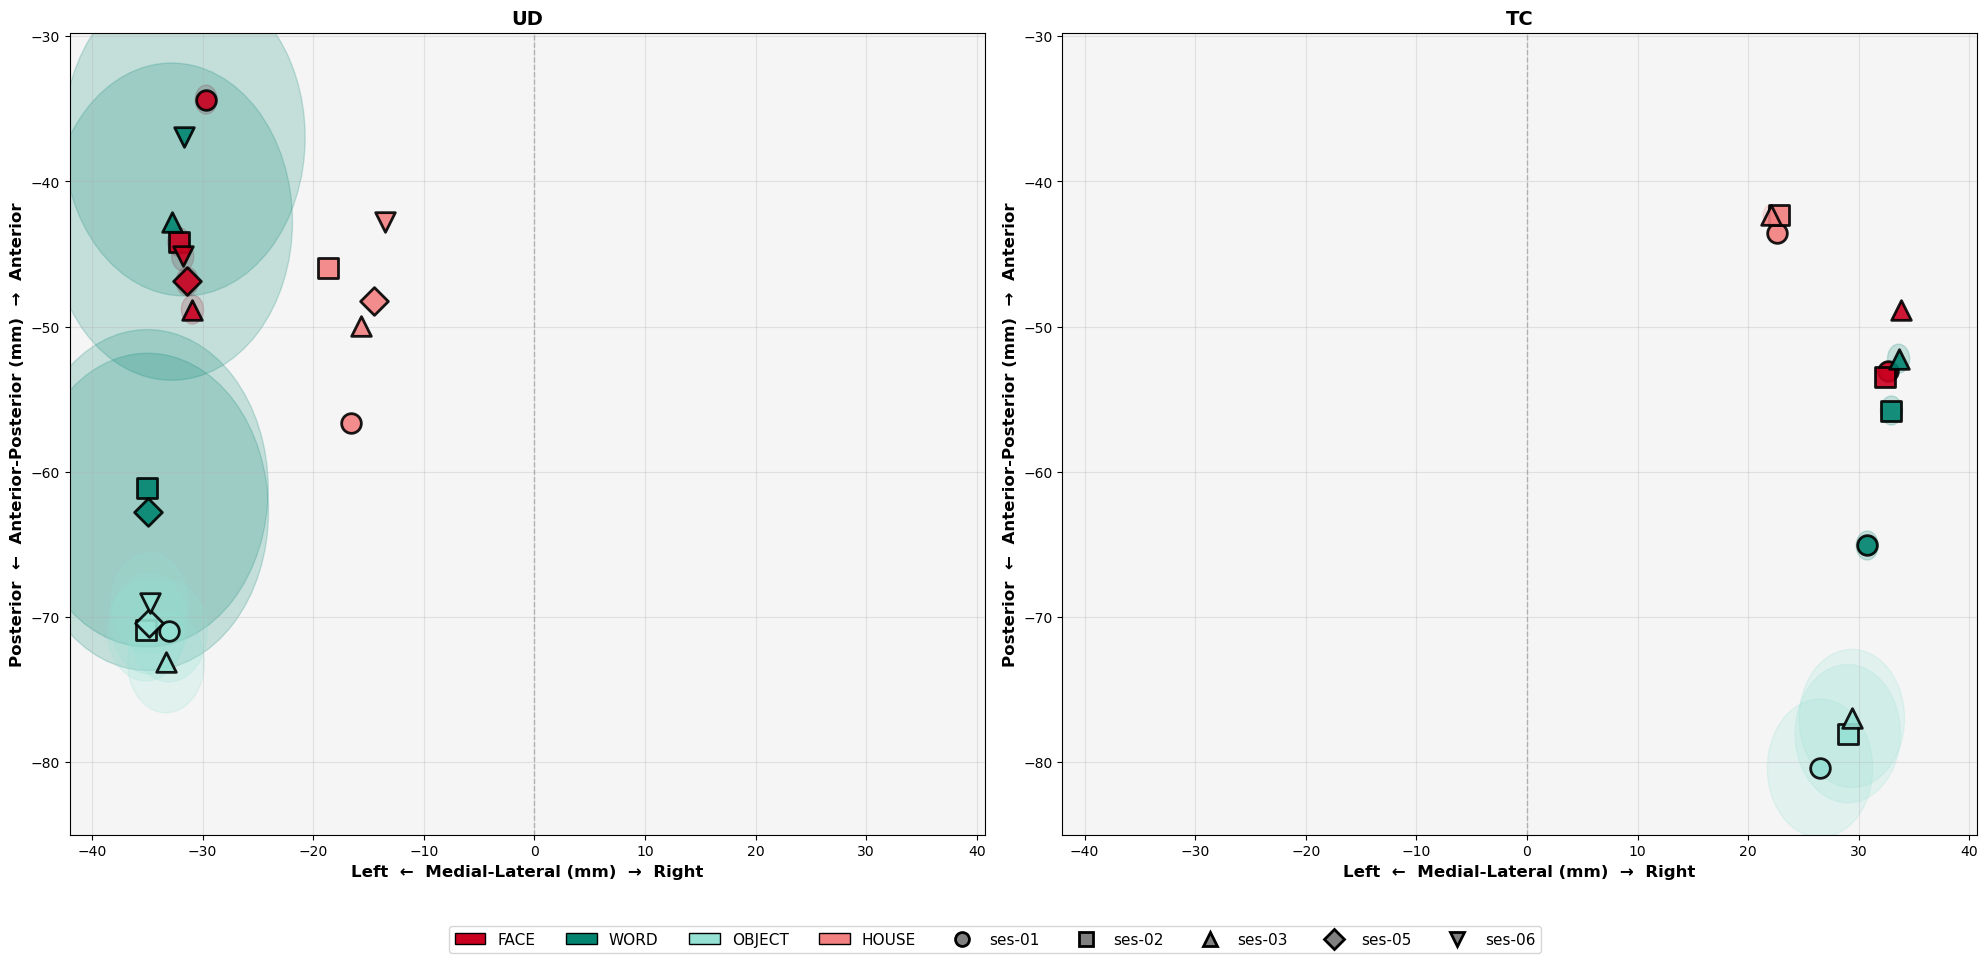

In [27]:
import numpy as np

def get_bootstrapped_error_radius(pair_peaks, n_bootstraps=5000, default_sd=1.0):
    """
    Calculates a bootstrapped estimate of the Euclidean SD of peak coordinates.

    With a small number of samples (e.g., run-pairs), a single SD 
    calculation is a noisy estimate. Bootstrapping provides a more 
    stable estimate of the underlying measurement error.

    Args:
        pair_peaks (list): List of peak dictionaries, e.g., [{'coord': [x, y, z]}, ...]
        n_bootstraps (int): Number of bootstrap iterations.
        default_sd (float): Value to return if calculation is not possible.

    Returns:
        float: The mean of the bootstrapped Euclidean SDs.
    """
    # 1. Get coordinates and handle cases with < 2 samples
    if not pair_peaks or len(pair_peaks) < 2:
        return default_sd
    
    data = np.array([p['coord'][:2] for p in pair_peaks]) # Use first 2 coords (x, y)
    n_samples = len(data)

    # 2. Define the statistic function (Euclidean SD)
    def stat_func(coords):
        # Need at least 2 points to calculate variance
        if len(np.unique(coords[:, 0])) < 2 or len(np.unique(coords[:, 1])) < 2:
            # If all resampled points are identical, SD is 0
            return 0.0
            
        std_x = np.std(coords[:, 0])
        std_y = np.std(coords[:, 1])
        return np.sqrt(std_x**2 + std_y**2)

    # 3. Run bootstrap
    bootstrapped_stats = []
    for _ in range(n_bootstraps):
        # Resample indices with replacement
        indices = np.random.choice(range(n_samples), size=n_samples, replace=True)
        resample = data[indices]
        
        # Calculate and store statistic for the resample
        bootstrapped_stats.append(stat_func(resample))
        
    # 4. Return the mean of the bootstrapped statistics
    final_radius = np.mean(bootstrapped_stats)
    
    # Handle rare cases where bootstrap might have failed (e.g., all nans)
    if np.isnan(final_radius) or final_radius == 0:
        # Fallback to simple calculation if bootstrap fails
        return stat_func(data) 
        
    return final_radius

import matplotlib.pyplot as plt
# Make sure numpy is imported, as the helper function needs it
import numpy as np 

# ... [Assume get_bootstrapped_error_radius is defined above] ...

def plot_topography_with_measurement_error(functional_results, peak_coords):
    """Use run-pair SD as measurement error haze (now bootstrapped)"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    
    colors = {
        'face': '#CA0020',
        'word': '#018571',
        'object': '#95E1D3',
        'house': '#F38181'
    }
    markers = {'01': 'o', '02': 's', '03': '^', '05': 'D', '06': 'v'}
    
    all_x, all_y = [], []
    
    for ax, subject_id in zip([ax1, ax2], ['sub-004', 'sub-021']):
        code = SUBJECTS[subject_id]['code']
        sessions = SUBJECTS[subject_id]['sessions']
        
        # ====================================================================
        # START: REPLACED CODE BLOCK
        # ====================================================================
        
        # Compute measurement error from run-pair peaks (bootstrapped)
        measurement_sds = {}
        print(f"\n{code} measurement error (bootstrapped run-pair SD):")
        
        for category, data in peak_coords[subject_id].items():
            pair_peaks = data.get('pair_peaks', []) # Use .get for safety
            
            # Use the new bootstrapped function to get a stable error estimate
            sd = get_bootstrapped_error_radius(pair_peaks, n_bootstraps=5000)
            measurement_sds[category] = sd
            print(f"  {category}: {sd:.2f}mm")

        # ====================================================================
        # END: REPLACED CODE BLOCK
        # ====================================================================
            
        for category in ['face', 'word', 'object', 'house']:
            if category not in functional_results[subject_id]:
                continue
            
            error_radius = measurement_sds.get(category, 1.0)
            
            for session in sessions:
                if session not in functional_results[subject_id][category]:
                    continue
                
                centroid = functional_results[subject_id][category][session]['centroid']
                x, y = centroid[0], centroid[1]
                
                all_x.append(x)
                all_y.append(y)
                
                # Plot measurement error haze
                circle = plt.Circle((x, y), error_radius, 
                                   color=colors[category], alpha=0.2, zorder=1)
                ax.add_patch(circle)
                
                # Plot centroid
                ax.scatter(x, y, c=colors[category], marker=markers.get(session, 'o'),
                          s=200, edgecolors='black', linewidth=2, alpha=0.9, zorder=3)
        
        ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_xlabel('Left  ←  Medial-Lateral (mm)  →  Right', fontsize=12, fontweight='bold')
        ax.set_ylabel('Posterior  ←  Anterior-Posterior (mm)  →  Anterior', fontsize=12, fontweight='bold')
        ax.set_title(f'{code}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_facecolor('#F5F5F5')
    
    x_margin = (max(all_x) - min(all_x)) * 0.1
    y_margin = (max(all_y) - min(all_y)) * 0.1
    
    xlim = [min(all_x) - x_margin, max(all_x) + x_margin]
    ylim = [min(all_y) - y_margin, max(all_y) + y_margin]
    
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    category_legend = [Patch(facecolor=colors[cat], edgecolor='black', label=cat.upper()) 
                      for cat in ['face', 'word', 'object', 'house']]
    session_legend = [Line2D([0], [0], marker=markers.get(s, 'o'), color='w', 
                            markerfacecolor='gray', markersize=10, 
                            markeredgecolor='black', markeredgewidth=2, label=f'ses-{s}')
                     for s in ['01', '02', '03', '05', '06']]
    
    fig.legend(handles=category_legend + session_legend, 
              loc='center', bbox_to_anchor=(0.5, -0.05), 
              ncol=9, fontsize=11, frameon=True)
    
    plt.tight_layout()
    # Ensure OUTPUT_DIR is defined
    # plt.savefig(OUTPUT_DIR / 'both_subjects_topography_measurement_error.png', dpi=300, bbox_inches='tight')
    plt.show()

# Your function call remains exactly the same
# (Assuming golarai_functional_final, ud_peaks, tc_peaks, and SUBJECTS are defined)

plot_topography_with_measurement_error(
     golarai_functional_final, 
     {'sub-004': ud_peaks, 'sub-021': tc_peaks}
 )